# Chapter 9 - Exercise 1
### Author: *John Benedick Estrada*
---
**Exercise:** Bill Bishop, author of *The Big Sort*, argues that
American society is increasingly segregated by political
opinion, as people choose to live among like-minded neighbors.

The mechanism Bishop hypothesizes is not that people, like the agents
in Schelling's model, are more likely to move if they are
isolated, but that when they move for any reason, they are
likely to choose a neighborhood with people like themselves.

Write a version of Schelling's model to simulate
this kind of behavior and see if it yields similar degrees of
segregation.

There are several ways you can model Bishop's hypothesis.  In my
implementation, a random selection of agents moves during each step.
Each agent considers `k` randomly-chosen empty locations and
chooses the one with the highest fraction of similar neighbors.
How does the degree of segregation depend on `k`?

You should be able to implement this model by inheriting from
`Schelling` and overriding `__init__` and `step`.

 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from Cell2D import Cell2D, draw_array
from matplotlib.colors import LinearSegmentedColormap
from utils import underride
from itertools import chain
from scipy.signal import correlate2d

### My interpretation of "The Big Sort" model

The model described in "The Big Sort" is similar in some respect to Schelling's model of segregation. There are two types agents: red and blue. A cell in the automaton can be occupied by an agent of either type or not. It only differs in the way the reason agents transfer from one cell to another.

##### Transfer condition
The transfer condition is similar to the one the author uses. In this CA, an agent may decide to move to another location. The probability that an agent will move is specified by the attribute `move_prob`. If an agent will transfer, it will then randomly select `k` number of empty cells and from the chosen empty cells, the agent will pick the location that has the most number of neighboring agents with the same color as its.

In this implementation, `BigSort` subclasses `Cell2D` and not `Schelling` which is what the author recommends us to use. This is for convenience and to avoid copy-pasting long lines of code.

In [2]:
class BigSort(Cell2D):
    # Representation of all cell states in this CA.
    EMPTY_CELL = 0
    BLUE_CELL = 1
    RED_CELL = 2
    
    # Color map to correctly display the agents.
    cmap = LinearSegmentedColormap.from_list(
                "bigsort_cmap",
                [(EMPTY_CELL/RED_CELL, "white"),
                 (BLUE_CELL/RED_CELL, "blue"), 
                 (RED_CELL/RED_CELL, "red")]
            )

    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.uint8)

    def __init__(self, n, move_prob, k, red_part=None, blue_part=None):
        self.move_prob = move_prob
        self.k = k

        # Initial portions of the array expressed as fractions.
        self.red_part = red_part if red_part is not None else 0.45
        self.blue_part = blue_part if blue_part is not None else 0.45
        self.empty_part = 1 - (self.red_part + self.blue_part)
        
        if self.empty_part < 0:
            raise ValueError("Red and blue parts are overlapping.")

        choices = [self.EMPTY_CELL, self.BLUE_CELL, self.RED_CELL]
        cell_prob = [self.empty_part,
                     self.red_part,
                     self.blue_part]
        self.array = np.random.choice(choices, size=(n, n), p=cell_prob)
    
    def draw(self, **options):
        options = underride(options, cmap=self.cmap)
        plt.xticks([])
        plt.yticks([])
        return plt.imshow(self.array, **options)
    
    def count_neighbor(self):
        """
        Based on the implementation of Schelling's model in Think Complexity
        Source: https://github.com/AllenDowney/ThinkComplexity2/blob/master/notebooks/chap09.ipynb (Cell 5)
        """
        # Get the array masking only one state.
        red_cells = (self.array == self.RED_CELL)
        blue_cells = (self.array == self.BLUE_CELL)
        empty_cells = (self.array == self.EMPTY_CELL)

        # Count the neighbors of specified cell state for each of the cell.
        corr_opt = dict(mode='same', boundary='wrap')
        red_neighbor = correlate2d(red_cells, self.kernel, **corr_opt)
        blue_neighbor = correlate2d(blue_cells, self.kernel, **corr_opt)
        total_neighbor = blue_neighbor + red_neighbor
        
        # For each occupied cell state (i.e. red & blue) for each cell,
        # get the degree of similarity of an agent of specific type with its
        # neighbor.
        frac_red = red_neighbor/total_neighbor
        frac_blue = blue_neighbor/total_neighbor
        frac_red[total_neighbor == 0] = 0
        frac_blue[total_neighbor == 0] = 0

        # Get the degree of similarity of an agent with its neighbors
        # expressed as fractions.
        # NOTE: Adopted from the book's implementation of Schelling's model.
        frac_same = np.where(red_cells, frac_red, frac_blue)
        frac_same[empty_cells] = np.nan
        
        return empty_cells, frac_red, frac_blue, frac_same
    
    def step(self):
        empty_cells, frac_red, frac_blue, frac_same = self.count_neighbor()

        # Find the locations of agents that will randomly move to elsewhere.
        r_arr = np.random.random(size=self.array.shape)
        moving_loc = zip_where(~empty_cells & (r_arr < self.move_prob))
        
        # Find the INITIAL locations of empty cells.
        # Note that once we start moving agents around, empty cells are filled
        # up and once occupied cells become vacant.
        # This list is updated everytime someone transfers.
        empty_loc = zip_where(self.array == self.EMPTY_CELL)
        # NOTE: `empty_loc_len` is supposed to stay constant since there
        #       will always be the same number of empty cells.
        empty_loc_len = len(empty_loc)
        
        for loc in moving_loc:
            # Find a list of random empty cells.
            rand_idx = np.random.choice(empty_loc_len, size=self.k)
            rand_frac = [frac_same[empty_loc[idx]] for idx in rand_idx]

            # Get the best location from the list of random empty cells for
            # the current agent, i.e. the agent in location `loc`.
            rand_frac_loc = np.argmax(rand_frac)
            next_loc = empty_loc[rand_idx[rand_frac_loc]]
            
            assert self.array[next_loc] == self.EMPTY_CELL, \
                    "Agent transfering to an occupied cell"

            # Transfer an agent to the best location from the randomly selected cells.
            cell_state = self.array[loc]
            self.array[loc] = self.EMPTY_CELL
            self.array[next_loc] = cell_state
            
            # Update the list of empty cell locations.
            empty_loc.append(loc)
            empty_loc.remove(next_loc)
    
    def segregation(self):
        """
        Directly obtained from the implementation of Schelling's model in Think Complexity
        Source: https://github.com/AllenDowney/ThinkComplexity2/blob/master/notebooks/chap09.ipynb (Cell 5)
        """
        _, _, _, frac_same = self.count_neighbor()
        # NOTE: Again, adopted from the book's implementation of Schelling' model.
        return np.nanmean(frac_same)


def zip_where(cond_arr):
    zipped_where_res = list(zip(*np.where(cond_arr)))
    return zipped_where_res

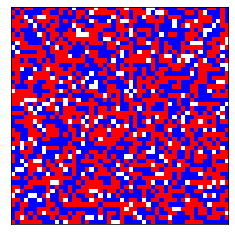

degree of segragation: 0.5000667556742323


In [3]:
bigsort_demo = BigSort(50, move_prob=0.1, k=10)
bigsort_demo.animate(100)
print("degree of segragation: {}".format(bigsort_demo.segregation()))